In [1]:
import warnings
warnings.filterwarnings('ignore')


# System Modelling and Analysis - Project
## Tappy keystroke data for early Parkinson Disease recognition


# Data load

In [2]:
from main import load_data

users_df, _, keystroke_df_list = load_data()

In [3]:
unique_users_count = len(users_df)
keystroke_count = len(keystroke_df_list)


print(f"Total users count: {unique_users_count}")
print(f"Keystroke records: {keystroke_count}")


Total users count: 227
Keystroke records: 2447450


In [4]:
%reload_ext autoreload


# Data visualization

Age distribution (parkinson / no parkinson):

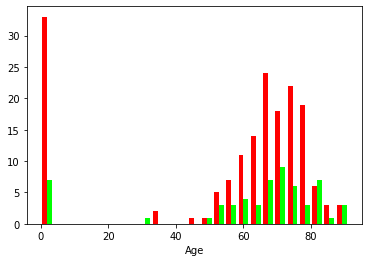

In [5]:
from render import render_age
render_age(users_df)

Gender distribution:

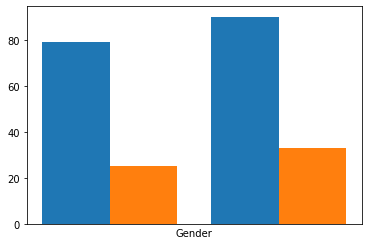

In [6]:
from render import render_gender
render_gender(users_df)

Diagnosis age:

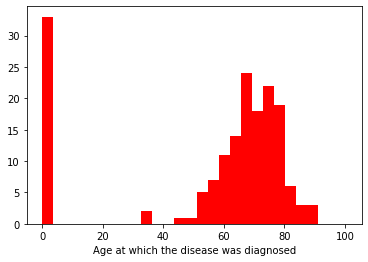

In [7]:
from render import render_diagnosis_age
render_diagnosis_age(users_df)

Parkinson's disease impact on daily life:

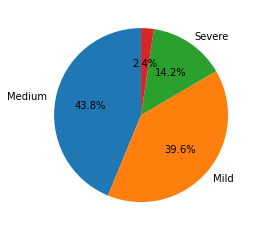

In [8]:
from render import render_impact
render_impact(users_df)

# Data filtering

For further analysis we use only cases with impact in group Severe, Mild and Medium.
Patients that under medicament will be also removed from analysis, because in their case the disease was already diagnosed and treatment was started.

Based on the article, number of participants with at least 2000 keystrokes was selected for further analysis.

In [9]:
impact_select = ["Severe", "Medium", "Mild"]

users_filtered_ids = set(
    users_df[
        (
            (users_df['parkinsons']) & (users_df['impact'].isin(impact_select)) | (~users_df['parkinsons'])
        )
        & (~users_df['levadopa'])
    ]['user_id']
)

keystroke_filtered_size = keystroke_df_list.groupby('user_id').size() >= 2000
keystroke_users_ids = set(keystroke_filtered_size.index[keystroke_filtered_size])

selected_users_ids = keystroke_users_ids.intersection(users_filtered_ids)


selected_users_count = len(selected_users_ids)

print(f"Users selected: {selected_users_count}")

Users selected: 54


parkinsons
False    27
True     27
dtype: int64


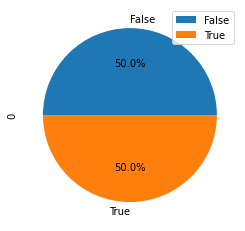

In [10]:
users_df_filtered = users_df.query("user_id in @selected_users_ids").groupby('parkinsons').size()
print(users_df_filtered)

from render import render_parkinson
render_parkinson(users_df_filtered.to_frame())

In [11]:
keystroke_df_filtered = keystroke_df_list[keystroke_df_list['user_id'].isin(selected_users_ids)]
keystroke_filtered_count = len(keystroke_df_filtered)

print(f"Keystrokes amount: {keystroke_filtered_count}")

Keystrokes amount: 1563846


In [12]:
keystroke_df_filtered.head()

,user_id,date,timestamp,hand,hold_time,direction,latency_time,flight_time
0,WBS5I7VF1G,161101,09:08:38.391,R,250.0,RR,484.4,234.4
1,WBS5I7VF1G,161101,09:08:38.562,R,109.4,RR,312.5,62.5
2,WBS5I7VF1G,161101,09:08:39.578,R,109.4,RR,234.4,375.0
3,WBS5I7VF1G,161101,09:08:39.656,R,187.5,RR,234.4,375.0
4,WBS5I7VF1G,161101,09:08:39.875,L,187.5,RL,218.8,31.3


# Preparation

Values such as mean, standard deviation, skewness and kurtosis were calculated

In [13]:
import numpy as np
from scipy.stats import skew, kurtosis

hold_ds_times =  keystroke_df_filtered[keystroke_df_filtered['hand'] != 'S'].groupby(['user_id', 'hand'])['hold_time'].agg([np.mean, np.std, skew, kurtosis])
hold_ds_times.head(4)

mean        std      skew  kurtosis
user_id    hand                                           
48DZPAJ5NS L     126.378427  21.759433  0.372987  6.147634
           R     126.405226  20.466488 -0.002474  6.900936
5ARV4LHEJ0 L      93.431707  24.011274  0.689511  2.806128
           R      88.428527  23.680331  0.668709  0.853400

In [14]:
latency_ds_times = keystroke_df_filtered[np.isin(keystroke_df_filtered['direction'], ['LL', 'LR', 'RL', 'RR'])].groupby(['user_id', 'direction'])['latency_time'].agg([np.mean, np.std, skew, kurtosis])
latency_ds_times.head(8)


mean         std      skew  kurtosis
user_id    direction                                            
48DZPAJ5NS LL         301.198111   84.091268  0.365716 -0.642791
           LR         334.454579   81.665918  0.015188 -0.745299
           RL         322.209030   89.614327  0.110617 -0.916372
           RR         332.435753   91.564317 -0.090278 -1.003347
5ARV4LHEJ0 LL         268.576996  122.763166  1.799560  3.727734
           LR         257.853434  156.928555  1.619512  1.862982
           RL         231.264469  134.013156  2.094706  4.446780
           RR         266.543327  118.495153  2.083482  4.961589

In [15]:
from helpers import make_flat
hold_time_flat = make_flat(hold_ds_times)
hold_time_flat['mean_diff'] = hold_time_flat['mean_L'] - hold_time_flat['mean_R']

hold_time_flat.head(10)

,mean_L,mean_R,std_L,std_R,skew_L,skew_R,kurtosis_L,kurtosis_R,mean_diff
user_id,,,,,,,,,
48DZPAJ5NS,126.378427,126.405226,21.759433,20.466488,0.372987,-0.002474,6.147634,6.900936,-0.026799
5ARV4LHEJ0,93.431707,88.428527,24.011274,23.680331,0.689511,0.668709,2.806128,0.853400,5.003180
5USOYSDCXB,72.152276,74.706504,26.076473,23.756390,0.141122,-0.265969,0.888681,1.671472,-2.554228
6LB9FQABZQ,127.508963,99.482716,67.450165,48.432031,0.242160,-0.049696,-0.134969,-0.460744,28.026247
81NEUZEBXI,133.631381,131.893691,38.221705,41.164102,0.453986,0.193605,1.359421,0.864619,1.737690
8O9IAIA9L1,86.372264,98.475048,32.266916,49.480572,0.926908,22.776487,2.932109,1131.441136,-12.102785
927ZLCPEJM,104.599705,117.972560,27.366840,26.940411,0.341266,-0.357819,2.305457,3.794348,-13.372854
95S93AXF86,98.800287,97.001564,47.753210,37.932468,-0.144255,0.115402,-0.524908,0.986424,1.798723
9RCEHVGNCJ,124.886219,123.508017,66.392988,31.009290,-0.194508,-0.559467,-0.901520,1.653063,1.378201


In [16]:
from helpers import make_flat
latency_flat = make_flat(latency_ds_times)
latency_flat['mean_LL_RR_diff'] = latency_flat['mean_LL'] - latency_flat['mean_RR']
latency_flat['mean_LR_RL_diff'] = latency_flat['mean_LR'] - latency_flat['mean_RL']
latency_flat.head(10)

,mean_LL,mean_LR,mean_RL,mean_RR,std_LL,std_LR,std_RL,std_RR,skew_LL,skew_LR,skew_RL,skew_RR,kurtosis_LL,kurtosis_LR,kurtosis_RL,kurtosis_RR,mean_LL_RR_diff,mean_LR_RL_diff
user_id,,,,,,,,,,,,,,,,,,
48DZPAJ5NS,301.198111,334.454579,322.209030,332.435753,84.091268,81.665918,89.614327,91.564317,0.365716,0.015188,0.110617,-0.090278,-0.642791,-0.745299,-0.916372,-1.003347,-31.237642,12.245549
5ARV4LHEJ0,268.576996,257.853434,231.264469,266.543327,122.763166,156.928555,134.013156,118.495153,1.799560,1.619512,2.094706,2.083482,3.727734,1.862982,4.446780,4.961589,2.033669,26.588964
5USOYSDCXB,177.817371,139.949558,145.719255,176.761511,85.552371,85.228366,93.083272,83.494383,1.835981,3.126761,2.885283,1.269504,8.081838,14.456914,11.615300,6.435207,1.055860,-5.769697
6LB9FQABZQ,189.406681,183.312808,148.136185,188.329619,137.634018,146.079655,113.116612,122.775802,1.901941,1.937972,2.712309,1.941850,3.925494,3.629987,8.834916,4.714036,1.077062,35.176623
81NEUZEBXI,311.996951,311.527273,280.362409,310.574742,91.820492,98.284819,124.448682,100.573153,0.082658,-0.183491,0.231058,-0.151052,-0.758685,-0.648496,-1.262872,-0.443301,1.422209,31.164864
8O9IAIA9L1,217.950469,203.057781,198.515992,215.587387,105.085081,115.010227,97.135607,113.738475,2.194407,2.198523,2.210455,2.046020,7.687335,5.908881,7.503160,5.253490,2.363081,4.541789
927ZLCPEJM,256.362932,243.541632,208.219976,273.082597,94.929267,102.672314,84.724671,87.830684,0.271723,0.644104,1.187708,0.194789,-0.231916,-0.530549,1.034039,0.252619,-16.719665,35.321656
95S93AXF86,202.549831,178.157775,171.992588,208.552174,99.650695,122.142773,113.638083,126.835640,2.294134,2.411635,2.602769,1.911277,7.899722,6.383411,8.329947,4.622506,-6.002343,6.165188
9RCEHVGNCJ,288.217878,204.609715,228.220711,293.373540,127.869740,128.307390,107.263006,124.914302,0.698635,1.857535,1.502823,1.120612,0.770035,3.666913,3.544747,1.760749,-5.155662,-23.610996


In [17]:
import pandas as pd
user_full_flat = pd.concat([hold_time_flat, latency_flat], axis=1)

user_full_flat.head(5)

,mean_L,mean_R,std_L,std_R,skew_L,skew_R,kurtosis_L,kurtosis_R,mean_diff,mean_LL,...,skew_LL,skew_LR,skew_RL,skew_RR,kurtosis_LL,kurtosis_LR,kurtosis_RL,kurtosis_RR,mean_LL_RR_diff,mean_LR_RL_diff
user_id,,,,,,,,,,,,,,,,,,,,,
48DZPAJ5NS,126.378427,126.405226,21.759433,20.466488,0.372987,-0.002474,6.147634,6.900936,-0.026799,301.198111,...,0.365716,0.015188,0.110617,-0.090278,-0.642791,-0.745299,-0.916372,-1.003347,-31.237642,12.245549
5ARV4LHEJ0,93.431707,88.428527,24.011274,23.680331,0.689511,0.668709,2.806128,0.853400,5.003180,268.576996,...,1.799560,1.619512,2.094706,2.083482,3.727734,1.862982,4.446780,4.961589,2.033669,26.588964
5USOYSDCXB,72.152276,74.706504,26.076473,23.756390,0.141122,-0.265969,0.888681,1.671472,-2.554228,177.817371,...,1.835981,3.126761,2.885283,1.269504,8.081838,14.456914,11.615300,6.435207,1.055860,-5.769697
6LB9FQABZQ,127.508963,99.482716,67.450165,48.432031,0.242160,-0.049696,-0.134969,-0.460744,28.026247,189.406681,...,1.901941,1.937972,2.712309,1.941850,3.925494,3.629987,8.834916,4.714036,1.077062,35.176623
81NEUZEBXI,133.631381,131.893691,38.221705,41.164102,0.453986,0.193605,1.359421,0.864619,1.737690,311.996951,...,0.082658,-0.183491,0.231058,-0.151052,-0.758685,-0.648496,-1.262872,-0.443301,1.422209,31.164864


In [18]:
user_full = pd.merge(user_full_flat.reset_index(), users_df[['user_id', 'parkinsons']], on='user_id')
user_full.set_index('user_id', inplace=True)
user_full.head()

,mean_L,mean_R,std_L,std_R,skew_L,skew_R,kurtosis_L,kurtosis_R,mean_diff,mean_LL,...,skew_LR,skew_RL,skew_RR,kurtosis_LL,kurtosis_LR,kurtosis_RL,kurtosis_RR,mean_LL_RR_diff,mean_LR_RL_diff,parkinsons
user_id,,,,,,,,,,,,,,,,,,,,,
48DZPAJ5NS,126.378427,126.405226,21.759433,20.466488,0.372987,-0.002474,6.147634,6.900936,-0.026799,301.198111,...,0.015188,0.110617,-0.090278,-0.642791,-0.745299,-0.916372,-1.003347,-31.237642,12.245549,True
5ARV4LHEJ0,93.431707,88.428527,24.011274,23.680331,0.689511,0.668709,2.806128,0.853400,5.003180,268.576996,...,1.619512,2.094706,2.083482,3.727734,1.862982,4.446780,4.961589,2.033669,26.588964,True
5USOYSDCXB,72.152276,74.706504,26.076473,23.756390,0.141122,-0.265969,0.888681,1.671472,-2.554228,177.817371,...,3.126761,2.885283,1.269504,8.081838,14.456914,11.615300,6.435207,1.055860,-5.769697,True
6LB9FQABZQ,127.508963,99.482716,67.450165,48.432031,0.242160,-0.049696,-0.134969,-0.460744,28.026247,189.406681,...,1.937972,2.712309,1.941850,3.925494,3.629987,8.834916,4.714036,1.077062,35.176623,False
81NEUZEBXI,133.631381,131.893691,38.221705,41.164102,0.453986,0.193605,1.359421,0.864619,1.737690,311.996951,...,-0.183491,0.231058,-0.151052,-0.758685,-0.648496,-1.262872,-0.443301,1.422209,31.164864,False


# Visualize Calculated data


In [19]:
import umap.umap_ as umap
umap_model = umap.UMAP()
embed = umap_model.fit_transform(user_full.iloc[:, :-1], user_full.iloc[:, -1])

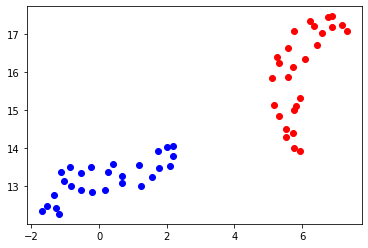

In [20]:
import matplotlib.pyplot as plt
not_peak = user_full.parkinsons.map(lambda x: not x)
plt.scatter(embed[user_full.parkinsons, 0], embed[user_full.parkinsons, 1], color="red")
plt.scatter(embed[not_peak, 0], embed[not_peak, 1], color="blue")

From the chart above, you can see that the data for people with Parkinson's disease are separate from the control group.
On this basis, I conclude that using the SVM models is a good choice.

# Support Vector Machine (SVM) #1


In [21]:
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.svm import LinearSVC
model = LinearSVC(
    multi_class='ovr',
    loss='squared_hinge',
    max_iter=1000,
)

train_X = np.concatenate([user_full.iloc[:, :-1], pd.DataFrame(embed)], axis=1)
train_y = user_full.iloc[:, -1]

scoring = ['accuracy', 'f1', 'roc_auc']
scores = cross_validate(
    model,
    train_X,
    train_y,
    cv=StratifiedKFold(n_splits=5, random_state=10, shuffle=True),
    scoring=scoring,
    return_train_score=True,
)

In [22]:
result = pd.DataFrame(scores)
result


,fit_time,score_time,test_accuracy,train_accuracy,test_f1,train_f1,test_roc_auc,train_roc_auc
0,0.002287,0.001783,0.727273,0.813953,0.800000,0.840000,1.0,1.000000
1,0.002032,0.001166,1.000000,1.000000,1.000000,1.000000,1.0,1.000000
2,0.002138,0.001144,1.000000,1.000000,1.000000,1.000000,1.0,1.000000
3,0.001993,0.001148,0.909091,0.976744,0.888889,0.977778,1.0,0.952381
4,0.002138,0.001123,1.000000,1.000000,1.000000,1.000000,1.0,1.000000


# Support Vector Machine (SVM) #2


In [23]:
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.svm import LinearSVC
model = LinearSVC(
    loss='hinge',
    multi_class="crammer_singer",
    max_iter=200,
)

train_X = np.concatenate([user_full.iloc[:, :-1], pd.DataFrame(embed)], axis=1)
train_y = user_full.iloc[:, -1]

scoring = ['accuracy', 'f1', 'roc_auc']
scores = cross_validate(
    model,
    train_X,
    train_y,
    cv=None,
    scoring=scoring,
    return_train_score=True,
)

In [24]:
result = pd.DataFrame(scores)
result




,fit_time,score_time,test_accuracy,train_accuracy,test_f1,train_f1,test_roc_auc,train_roc_auc
0,0.424536,0.001642,0.909091,1.0,0.923077,1.0,0.800000,1.0
1,0.496860,0.001583,1.000000,1.0,1.000000,1.0,1.000000,1.0
2,0.597418,0.001620,1.000000,1.0,1.000000,1.0,1.000000,1.0
3,0.535513,0.001626,0.909091,1.0,0.909091,1.0,0.833333,1.0
4,0.570103,0.001605,1.000000,1.0,1.000000,1.0,1.000000,1.0


# Random Forest #1


In [25]:
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(
    n_estimators=100,
    criterion="gini",
)

train_X = np.concatenate([user_full.iloc[:, :-1], pd.DataFrame(embed)], axis=1)
train_y = user_full.iloc[:, -1]

scoring = ['accuracy', 'f1', 'roc_auc']
scores = cross_validate(
    model,
    train_X,
    train_y,
    cv=StratifiedKFold(n_splits=5, random_state=1337, shuffle=True),
    scoring=scoring,
    return_train_score=True
)

In [26]:
result = pd.DataFrame(scores)
result





,fit_time,score_time,test_accuracy,train_accuracy,test_f1,train_f1,test_roc_auc,train_roc_auc
0,0.056835,0.010102,1.0,1.0,1.0,1.0,1.0,1.0
1,0.057510,0.009912,1.0,1.0,1.0,1.0,1.0,1.0
2,0.056820,0.010127,1.0,1.0,1.0,1.0,1.0,1.0
3,0.056407,0.009885,1.0,1.0,1.0,1.0,1.0,1.0
4,0.056202,0.009896,1.0,1.0,1.0,1.0,1.0,1.0


# Random Forest #2


In [27]:
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(
    n_estimators=10,
    criterion="entropy",
)

train_X = np.concatenate([user_full.iloc[:, :-1], pd.DataFrame(embed)], axis=1)
train_y = user_full.iloc[:, -1]

scoring = ['accuracy', 'f1', 'roc_auc']
scores = cross_validate(
    model,
    train_X,
    train_y,
    cv=None,
    scoring=scoring,
    return_train_score=True
)

In [28]:
result = pd.DataFrame(scores)
result



,fit_time,score_time,test_accuracy,train_accuracy,test_f1,train_f1,test_roc_auc,train_roc_auc
0,0.006779,0.002750,1.000000,1.0,1.000000,1.0,1.000000,1.0
1,0.006420,0.002528,1.000000,1.0,1.000000,1.0,1.000000,1.0
2,0.006261,0.002311,0.909091,1.0,0.888889,1.0,0.966667,1.0
3,0.006494,0.002424,1.000000,1.0,1.000000,1.0,1.000000,1.0
4,0.006275,0.002472,1.000000,1.0,1.000000,1.0,1.000000,1.0
